 CMR Vanish Experiment
1. Run VANISH with CMR (exact)
2. Run VANISH with CMR (fast)
3. Exit


Select an option (1/2/3):  2


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.8MB/s]


DEVICE: cuda
CFG summary: {'epochs': 10, 'lr': 0.001, 'depth': 15, 'width': 256, 'CMR_MODE': 'fast'}

Running VANISH scenario
--Vanilla-- Epoch  1 | Test Acc: 0.1794 | Avg Grad: 7.843e-01 | FrontGrad: 3.9e-02 | BackGrad: 1.1e-01 | tiny%:  8.7 | Stable %:  98.1 | Avg κ: 3591.8 | Max|s_k|: 0.995 | ~σ_max=3.56 | ~σ_min=5.20e-03 | ~κ≈6.86e+02 | lam=0.0000
--Vanilla-- Epoch  2 | Test Acc: 0.1950 | Avg Grad: 8.441e-01 | FrontGrad: 4.2e-02 | BackGrad: 1.2e-01 | tiny%:  0.2 | Stable %:  99.4 | Avg κ: 10772.9 | Max|s_k|: 0.995 | ~σ_max=3.63 | ~σ_min=5.22e-03 | ~κ≈6.96e+02 | lam=0.0000
--Vanilla-- Epoch  3 | Test Acc: 0.2029 | Avg Grad: 7.577e-01 | FrontGrad: 3.5e-03 | BackGrad: 1.1e-01 | tiny%:  0.3 | Stable %:  99.8 | Avg κ: 3984.8 | Max|s_k|: 0.995 | ~σ_max=3.70 | ~σ_min=5.36e-03 | ~κ≈6.91e+02 | lam=0.0000
--Vanilla-- Epoch  4 | Test Acc: 0.1028 | Avg Grad: 1.139e+00 | FrontGrad: 1.5e-03 | BackGrad: 1.6e-01 | tiny%:  0.8 | Stable %: 100.0 | Avg κ: 11634.1 | Max|s_k|: 0.994 | ~σ_max=4.02 | ~σ_

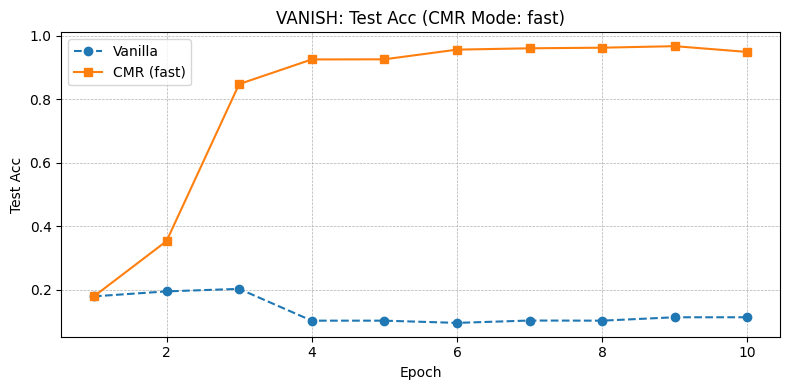

In [1]:
from __future__ import annotations
import os, math, random, pickle
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt

Tensor = torch.Tensor

class CMR:
    def __init__(self,
                 K: int = 5,
                 beta: float = 0.15,
                 lam: float = 0.02,
                 alpha1: float = 1.0,
                 alpha2: float = 0.1,
                 rho_spec: float = 0.5,
                 warmup_steps: int = 1000,
                 eps: float = 1e-6,
                 delta: float = 1e-12,
                 hutch_samples: int = 8,
                 eig_method: str = 'gram_eigh',
                 max_eigh_dim: int = 2048,
                 mode: str = "exact",
                 device: Optional[torch.device] = None,
                 verbose: bool = False):
        assert K >= 3
        assert 0 < rho_spec <= 1.0
        assert mode in ("fast","exact")
        self.K = K
        self.beta = beta
        self.lam = lam
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.rho_spec = rho_spec
        self.warmup_steps = warmup_steps
        self.eps = eps
        self.delta = delta
        self.hutch_samples = hutch_samples
        self.eig_method = eig_method
        self.max_eigh_dim = max_eigh_dim
        self.mode = mode
        self.device = device
        self.verbose = verbose
        self._register_moment_weights()

    def set_mode(self, mode: str):
        assert mode in ("fast","exact")
        self.mode = mode

    @torch.no_grad()
    def lambda_t(self, t: int) -> float:
        if self.warmup_steps <= 0:
            return float(self.lam)
        return float(self.lam) * min(1.0, float(t) / float(self.warmup_steps))

    def step(self,
             model: nn.Module,
             task_loss: Tensor,
             optimizer: torch.optim.Optimizer,
             t: int,
             retain_graph: bool = False) -> Dict[str, float]:

        params = [p for p in model.parameters() if p.requires_grad]
        if len(params) == 0:
            return {}

        dev = self._infer_device(params)

        g_task = torch.autograd.grad(task_loss, params,
                                      retain_graph=True,
                                      create_graph=False,
                                      allow_unused=True)

        lam_t = self.lambda_t(t)
        spec_loss, spec_stats = self._spectral_penalty(model, device=dev)
        spec_loss = lam_t * spec_loss

        g_spec = torch.autograd.grad(spec_loss, params,
                                      retain_graph=retain_graph,
                                      create_graph=False,
                                      allow_unused=True)

        g_task_norm = self._global_norm(g_task)
        g_spec_norm = self._global_norm(g_spec)
        gamma = 0.0
        if g_spec_norm > 0.0:
            gamma = min(1.0, float(self.rho_spec * (g_task_norm / (g_spec_norm + self.delta))))

        with torch.no_grad():
            for p, gt, gs in zip(params, g_task, g_spec):
                if p is None:
                    continue
                g = torch.zeros_like(p) if gt is None else gt.clone()
                if gs is not None:
                    g.add_(gs, alpha=gamma)
                p.grad = g

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        return {
            "lambda_t": lam_t,
            "gamma": float(gamma),
            "g_task_norm": float(g_task_norm),
            "g_spec_norm": float(g_spec_norm),
            "spec_loss": float(spec_loss.detach().cpu()),
            "cond_mean": float(spec_stats["cond_mean"]),
            "mom_mean": float(spec_stats["mom_mean"]),
            "mode": self.mode,
        }

    def spectral_penalty(self, model: nn.Module) -> Tensor:
        penalty, _ = self._spectral_penalty(model, device=self._infer_device([p for p in model.parameters() if p.requires_grad]))
        return penalty

    def _spectral_penalty(self, model: nn.Module, device: torch.device):
        cond_sum, mom_sum = [], []
        for name, W in self._iter_weight_matrices(model):
            W = W.to(device)
            if self.mode == "exact":
                lam_max, lam_min = self._gram_eig_extrema_exact(W)
                cond = 0.5 * (torch.log(lam_max + 1e-30) - torch.log(lam_min + self.eps))
                mom  = self._moment_exact(W, lam_max=lam_max, lam_min=lam_min)
            else:
                lam_max, lam_min = self._gram_eig_extrema(W, method=self._choose_eig_method(W.shape[1]))
                cond = 0.5 * (torch.log(lam_max + 1e-30) - torch.log(lam_min + self.eps))
                mom  = self._moment_proxy(W, lam_max=lam_max, lam_min=lam_min)
            cond_sum.append(cond)
            mom_sum.append(mom)

        if not cond_sum:
            zero = torch.zeros([], device=device)
            return zero, dict(cond_mean=0.0, mom_mean=0.0)

        cond_total = torch.stack(cond_sum).sum()
        mom_total  = torch.stack(mom_sum).sum()
        penalty = self.alpha1 * cond_total + self.alpha2 * mom_total
        stats = dict(
            cond_mean=float(torch.stack(cond_sum).mean().detach().cpu()),
            mom_mean=float(torch.stack(mom_sum).mean().detach().cpu())
        )
        return penalty, stats

    def _moment_proxy(self, W: Tensor, lam_max: Tensor, lam_min: Tensor) -> Tensor:
        m, n = W.shape
        device = W.device
        c = 0.5 * (lam_max + lam_min)
        d = torch.maximum(0.5 * (lam_max - lam_min), torch.tensor(self.eps, device=device))

        def Ghat_mv(x: Tensor) -> Tensor:
            y = W @ x
            y = W.t() @ y
            y = (y - c * x) / d
            return y

        S = self.hutch_samples
        if S <= 0:
            return torch.zeros([], device=device)

        Z = torch.empty((n, S), device=device).bernoulli_().mul_(2.0).add_(-1.0)
        V_prev = Z
        V_cur  = Ghat_mv(Z)
        s_vals: List[Tensor] = []

        V_next = 2.0 * Ghat_mv(V_cur) - V_prev
        k = 2
        while k < self.K:
            V_prev, V_cur = V_cur, V_next
            k += 1
            z_dot = (Z * V_cur).sum(dim=0)
            s_k_est = z_dot.mean() / float(n)
            if k >= 3:
                s_vals.append(s_k_est)
            if k < self.K:
                V_next = 2.0 * Ghat_mv(V_cur) - V_prev

        if not s_vals:
            return torch.zeros([], device=device)
        s_vec = torch.stack(s_vals)
        w_vec = self._w_vec.to(device=device, dtype=s_vec.dtype)
        return torch.sum(w_vec * (s_vec ** 2))

    def _moment_exact(self, W: Tensor, lam_max: Tensor, lam_min: Tensor) -> Tensor:
        G = W.t() @ W
        n = G.shape[0]
        c = 0.5*(lam_max + lam_min)
        d = torch.clamp(0.5*(lam_max - lam_min), min=self.eps)
        I = torch.eye(n, device=G.device, dtype=G.dtype)
        Ghat = (G - c*I) / d
        Tkm1, Tk = I, Ghat
        loss = torch.zeros([], device=G.device, dtype=G.dtype)
        for k in range(2, self.K+1):
            Tkp1 = 2*Ghat @ Tk - Tkm1
            if k >= 3:
                s_k = torch.trace(Tkp1) / n
                w   = torch.exp(torch.tensor(self.beta*(k-3), device=G.device, dtype=G.dtype))
                loss = loss + w * (s_k*s_k)
            Tkm1, Tk = Tk, Tkp1
        return loss

    def _choose_eig_method(self, n: int) -> str:
        if self.eig_method in ("gram_eigh", "power"):
            return self.eig_method
        return "gram_eigh" if n <= self.max_eigh_dim else "power"

    def _gram_eig_extrema_exact(self, W: Tensor):
        G = W.t() @ W
        G = 0.5 * (G + G.t())
        evals = torch.linalg.eigvalsh(G)
        lam_min = torch.clamp(evals[0], min=0.0)
        lam_max = torch.clamp(evals[-1], min=0.0)
        return lam_max, lam_min

    def _gram_eig_extrema(self, W: Tensor, method: str = "gram_eigh"):
        if method == "gram_eigh":
            return self._gram_eig_extrema_exact(W)

        def G_mv(x: Tensor) -> Tensor:
            return W.t() @ (W @ x)

        lam_max = self._power_iteration(G_mv, W.shape[1], W.device, iters=30)
        lam_min = self._inv_power_iteration_spd(G_mv, W.shape[1], W.device,
                                                shift=self.eps, iters=12,
                                                cg_iters=128, cg_tol=1e-5)
        lam_min = torch.clamp(lam_min, min=0.0)
        lam_max = torch.clamp(lam_max, min=0.0)
        return lam_max, lam_min

    @torch.no_grad()
    def _power_iteration(self, A_mv, n: int, device, iters: int = 30) -> Tensor:
        v = torch.randn(n, device=device)
        v = v / (v.norm() + 1e-30)
        lam = torch.tensor(0.0, device=device)
        for _ in range(iters):
            w = A_mv(v)
            normw = w.norm() + 1e-30
            v = w / normw
            lam = torch.dot(v, A_mv(v))
        return lam

    @torch.no_grad()
    def _inv_power_iteration_spd(self, A_mv, n: int, device, shift: float,
                                 iters: int = 12, cg_iters: int = 128, cg_tol: float = 1e-5) -> Tensor:
        def solve_shifted(b: Tensor) -> Tensor:
            x = torch.zeros_like(b)
            r = b.clone()
            p = r.clone()
            rs_old = torch.dot(r, r)
            for _ in range(cg_iters):
                Ap = A_mv(p) + shift * p
                alpha = rs_old / (torch.dot(p, Ap) + 1e-30)
                x = x + alpha * p
                r = r - alpha * Ap
                rs_new = torch.dot(r, r)
                if torch.sqrt(rs_new) < cg_tol:
                    break
                p = r + (rs_new / (rs_old + 1e-30)) * p
                rs_old = rs_new
            return x

        v = torch.randn(n, device=device)
        v = v / (v.norm() + 1e-30)
        lam_inv = torch.tensor(0.0, device=device)
        for _ in range(iters):
            y = solve_shifted(v)
            v = y / (y.norm() + 1e-30)
            num = torch.dot(v, solve_shifted(v))
            den = torch.dot(v, v) + 1e-30
            lam_inv = num / den
        return torch.relu(1.0 / (lam_inv + 1e-30) - shift)

    def _iter_weight_matrices(self, model: nn.Module):
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear) and module.weight is not None:
                yield name, module.weight
            elif isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d)) and module.weight is not None:
                W = module.weight
                out_c = W.shape[0]
                yield name, W.view(out_c, -1)

    def _global_norm(self, grads: List[Optional[Tensor]]) -> float:
        sq = 0.0
        for g in grads:
            if g is not None:
                sq += float(torch.sum(g.detach()**2).cpu())
        return math.sqrt(sq)

    def _infer_device(self, params: List[Tensor]) -> torch.device:
        if self.device is not None:
            return torch.device(self.device)
        for p in params:
            if p is not None:
                return p.device
        return torch.device("cpu")

    def _register_moment_weights(self):
        ks = torch.arange(3, self.K + 1, dtype=torch.float32)
        self._w_vec = torch.exp(self.beta * (ks - 3.0))

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class MNISTDataModule:
    def __init__(self, root="./data", batch_size=128, ntrain=None, ntest=None, seed=42, num_workers=0):
        self.root = root; self.batch_size = batch_size
        self.ntrain = ntrain; self.ntest = ntest
        self.seed = seed; self.num_workers = num_workers

    def make_loaders(self) -> Tuple[DataLoader, DataLoader]:
        tfm = transforms.Compose([transforms.ToTensor()])
        train = datasets.MNIST(root=self.root, train=True, download=True, transform=tfm)
        test  = datasets.MNIST(root=self.root, train=False, download=True, transform=tfm)

        if self.ntrain is not None and self.ntrain < len(train):
            rng = np.random.default_rng(self.seed)
            idx = rng.choice(len(train), size=self.ntrain, replace=False)
            train = Subset(train, idx.tolist())
        if self.ntest is not None and self.ntest < len(test):
            rng = np.random.default_rng(self.seed + 1)
            idx = rng.choice(len(test), size=self.ntest, replace=False)
            test = Subset(test, idx.tolist())

        g = torch.Generator().manual_seed(self.seed)
        train_loader = DataLoader(train, batch_size=self.batch_size, shuffle=True,
                                  num_workers=self.num_workers, pin_memory=True,
                                  worker_init_fn=seed_worker, generator=g)
        test_loader  = DataLoader(test, batch_size=512, shuffle=False,
                                  num_workers=self.num_workers, pin_memory=True)
        return train_loader, test_loader

class DeepMLP(nn.Module):
    def __init__(self, depth=15, width=256, num_classes=10,
                 activation='tanh', input_scale=1.0,
                 layer_gain=1.0, bias_shift=0.0):
        super().__init__()
        self.activation = activation
        self.input_scale = float(input_scale)
        self.layer_gain = float(layer_gain)
        self.bias_shift = float(bias_shift)
        self.collect_preacts = False
        self.last_preacts = []
        layers = []
        in_dim = 28*28
        for _ in range(depth - 1):
            layers.append(nn.Linear(in_dim, width))
            in_dim = width
        layers.append(nn.Linear(in_dim, num_classes))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1) * self.input_scale
        for i, lin in enumerate(self.layers):
            x = lin(x)
            if i < len(self.layers) - 1:
                if self.layer_gain != 1.0: x = x * self.layer_gain
                if self.bias_shift != 0.0: x = x + self.bias_shift
                if self.activation == 'tanh':
                    x = torch.tanh(x)
                elif self.activation == 'relu':
                    x = F.relu(x, inplace=True)
                else:
                    x = F.gelu(x)
        return x

class AdversarialInit:
    @staticmethod
    def _orthogonal_scaled_(lin: nn.Linear, scale: float):
        nn.init.orthogonal_(lin.weight, gain=1.0)
        with torch.no_grad():
            lin.weight.mul_(float(scale))
            if lin.bias is not None:
                lin.bias.zero_()

    @classmethod
    def baseline(cls, model: nn.Module, vanish_scale: float = 0.06):
        scale = float(vanish_scale)
        for m in model.modules():
            if isinstance(m, nn.Linear):
                cls._orthogonal_scaled_(m, scale)

    @classmethod
    def spectral_decay(cls, model: nn.Module, base=0.8, decay=0.95):
        l = 0
        for m in model.modules():
            if isinstance(m, nn.Linear):
                sc = float(base * (decay ** l))
                cls._orthogonal_scaled_(m, sc)
                l += 1

class Metrics:
    @staticmethod
    @torch.no_grad()
    def evaluate(model: nn.Module, loader, device: torch.device) -> float:
        model.eval()
        correct, total = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
        return correct / max(1, total)

    @staticmethod
    @torch.no_grad()
    def kappa_stats(model: nn.Module, eps: float = 1e-8) -> float:
        vals = []
        for m in model.modules():
            if isinstance(m, nn.Linear):
                s = torch.linalg.svdvals(m.weight.detach())
                if s.numel() >= 1:
                    vals.append(float(s[0].item() / (s[-1].item() + eps)))
        return float(np.mean(vals)) if vals else float('nan')

    @staticmethod
    @torch.no_grad()
    def sigma_stats(model: nn.Module, eps: float = 1e-8) -> Dict[str,float]:
        Ws=[]
        for m in model.modules():
            if isinstance(m, nn.Linear) and m.weight is not None:
                Ws.append(m.weight.detach())
        if len(Ws) <= 1:
            return dict(avg_smax=float('nan'), avg_smin=float('nan'), kappa=float('nan'))
        hidden = Ws[:-1]
        smax_list=[]; smin_list=[]
        for W in hidden:
            s=torch.linalg.svdvals(W)
            smax_list.append(float(s[0].item()))
            smin_list.append(float(s[-1].item()))
        avg_smax=float(np.mean(smax_list)) if smax_list else float('nan')
        avg_smin=float(np.mean(smin_list)) if smin_list else float('nan')
        kappa = float(avg_smax/max(avg_smin,1e-30))
        return dict(avg_smax=avg_smax, avg_smin=avg_smin, kappa=kappa)

    @staticmethod
    def grad_per_layer(model: nn.Module):
        out = []
        for name, m in model.named_modules():
            if isinstance(m, nn.Linear):
                g = 0.0
                if m.weight.grad is not None:
                    g = float(m.weight.grad.detach().norm().item())
                out.append((name, g))
        return out

    @staticmethod
    def summarize_layer_grads(layer_grads, tiny=1e-7):
        vals = [g for _, g in layer_grads]
        if not vals:
            return dict(min=float('nan'), median=float('nan'), max=float('nan'), tiny_pct=float('nan'))
        vals_sorted = sorted(vals)
        n = len(vals)
        tiny_pct = 100.0 * sum(v < tiny for v in vals) / n
        return dict(min=min(vals), median=vals_sorted[n // 2], max=vals_sorted[-1], tiny_pct=tiny_pct)

    @staticmethod
    def grad_norm_params(params: List[torch.nn.Parameter]) -> float:
        s = 0.0
        for p in params:
            if p.grad is not None:
                s += p.grad.detach().pow(2).sum().item()
        return float(s ** 0.5)

    @staticmethod
    @torch.no_grad()
    def max_abs_moments(model: nn.Module, K: int = 5, eps: float = 1e-6) -> float:
        M = 0.0
        for m in model.modules():
            if isinstance(m, nn.Linear):
                G = m.weight.detach().T @ m.weight.detach()
                n = G.shape[0]
                evals = torch.linalg.eigvalsh(G)
                lam_min, lam_max = float(evals[0].item()), float(evals[-1].item())
                c = 0.5 * (lam_max + lam_min); d = max(0.5 * (lam_max - lam_min), eps)
                I = torch.eye(n, device=G.device, dtype=G.dtype)
                G_hat = (G - c*I) / d
                Tkm1, Tk = I, G_hat
                for k in range(2, K+1):
                    Tkp1 = 2*G_hat @ Tk - Tkm1
                    if k >= 3:
                        s_k = torch.trace(Tkp1).item() / n
                        M = max(M, abs(s_k))
                    Tkm1, Tk = Tk, Tkp1
        return float(M)

@dataclass
class TrainConfig:
    epochs: int = 5
    lr: float = 1e-3
    global_clip: float = 5.0
    stable_lo: float = 1e-3
    stable_hi: float = 3.0
    use_cmr: bool = False
    lam: float = 0.03
    lam_warmup: int = 3
    rho_spec: float = 0.5
    alpha1: float = 1.0
    alpha2: float = 0.1
    K: int = 5
    beta: float = 0.15
    eps: float = 1e-6
    hutch_samples: int = 8
    cmr_mode: str = "exact"
    eig_method: str = "gram_eigh"
    log_prefix: str = ""

class Trainer:
    def __init__(self, model: nn.Module, device: torch.device, config: TrainConfig):
        self.model = model.to(device)
        self.device = device
        self.cfg = config
        self.opt = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr)
        self.ce = nn.CrossEntropyLoss()
        self.params = [p for p in self.model.parameters() if p.requires_grad]
        self.cmr: Optional[CMR] = None
        if self.cfg.use_cmr:
            self.cmr = CMR(
                K=self.cfg.K, beta=self.cfg.beta, lam=self.cfg.lam,
                alpha1=self.cfg.alpha1, alpha2=self.cfg.alpha2,
                rho_spec=self.cfg.rho_spec, warmup_steps=self.cfg.lam_warmup,
                eps=self.cfg.eps, hutch_samples=self.cfg.hutch_samples,
                eig_method=self.cfg.eig_method,
                mode=self.cfg.cmr_mode,
            )

    def _warmup_lambda(self, epoch: int) -> float:
        if not self.cfg.use_cmr:
            return 0.0
        t = max(0, min(epoch, self.cfg.lam_warmup))
        return self.cfg.lam * (t / max(1, self.cfg.lam_warmup))

    def fit(self, train_loader, test_loader) -> List[Dict]:
        hist: List[Dict] = []
        global_step = 0

        for ep in range(1, self.cfg.epochs + 1):
            self.model.train()
            batch_gn = []
            stable_count, total_batches = 0, 0

            front_grads_epoch, back_grads_epoch = [], []
            tiny_hits_epoch, total_lin_epoch = 0, 0

            lam_eff = self._warmup_lambda(ep - 1)
            self.model.collect_preacts = False

            for x, y in train_loader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                loss_ce = self.ce(logits, y)

                self.opt.zero_grad(set_to_none=True)
                loss_ce.backward(retain_graph=True)
                layer_grads_ce = Metrics.grad_per_layer(self.model)
                stats_ce = Metrics.summarize_layer_grads(layer_grads_ce, tiny=1e-7)
                vals = [g for _, g in layer_grads_ce]
                if vals:
                    mid = len(vals) // 2
                    front_grads_epoch.append(float(np.mean(vals[:mid])))
                    back_grads_epoch.append(float(np.mean(vals[mid:])))
                    tiny_hits_epoch += sum(v < 1e-7 for v in vals)
                    total_lin_epoch += len(vals)

                self.opt.zero_grad(set_to_none=True)

                if self.cmr is None or lam_eff <= 0.0:
                    self.opt.zero_grad(set_to_none=True)
                    loss_ce.backward()
                    if self.cfg.global_clip and self.cfg.global_clip > 0:
                        torch.nn.utils.clip_grad_norm_(self.params, max_norm=self.cfg.global_clip)
                    gn = Metrics.grad_norm_params(self.params)
                    batch_gn.append(gn)
                    if self.cfg.stable_lo <= gn <= self.cfg.stable_hi:
                        stable_count += 1
                    total_batches += 1
                    self.opt.step()
                    self.opt.zero_grad(set_to_none=True)
                else:
                    stats = self.cmr.step(self.model, loss_ce, self.opt, global_step, retain_graph=False)
                    gn_est = (stats["g_task_norm"] ** 2 + (stats["gamma"] * stats["g_spec_norm"]) ** 2) ** 0.5
                    batch_gn.append(gn_est)
                    if self.cfg.stable_lo <= gn_est <= self.cfg.stable_hi:
                        stable_count += 1
                    total_batches += 1

                global_step += 1

            avg_grad = float(np.mean(batch_gn)) if batch_gn else float('nan')
            stable_pct = 100.0 * stable_count / max(1, total_batches)
            acc = Metrics.evaluate(self.model, test_loader, self.device)
            kappa = Metrics.kappa_stats(self.model, eps=1e-8)
            sig = Metrics.sigma_stats(self.model, eps=1e-8)
            max_s = Metrics.max_abs_moments(self.model, K=self.cfg.K, eps=self.cfg.eps)
            front_avg = float(np.mean(front_grads_epoch)) if front_grads_epoch else float('nan')
            back_avg  = float(np.mean(back_grads_epoch))  if back_grads_epoch  else float('nan')
            tiny_pct_epoch = 100.0 * tiny_hits_epoch / max(1, total_lin_epoch)

            print(f"{self.cfg.log_prefix} Epoch {ep:2d} | Test Acc: {acc:.4f} | Avg Grad: {avg_grad:.3e} "
                  f"| FrontGrad: {front_avg:.1e} | BackGrad: {back_avg:.1e} | tiny%: {tiny_pct_epoch:4.1f} "
                  f"| Stable %: {stable_pct:5.1f} | Avg κ: {kappa:.1f} | Max|s_k|: {max_s:.3f} "
                  f"| ~σ_max={sig['avg_smax']:.2f} | ~σ_min={sig['avg_smin']:.2e} | ~κ≈{sig['kappa']:.2e} | lam={lam_eff:.4f}")

            hist.append(dict(epoch=ep, acc=acc, avg_grad=avg_grad, stable_pct=stable_pct,
                             kappa=kappa, max_abs_s=max_s, lam=lam_eff,
                             front_grad_avg=front_avg, back_grad_avg=back_avg,
                             sigma_max=sig['avg_smax'], sigma_min=sig['avg_smin'], sigma_kappa=sig['kappa']))

        return hist

@dataclass
class ExperimentConfig:
    seed: int = 42
    epochs: int = 5
    batch_size: int = 128
    ntrain: Optional[int] = None
    ntest: Optional[int] = None
    num_workers: int = 0
    lr: float = 1e-3
    depth: int = 15
    width: int = 256
    activation: str = "tanh"
    vanish_scale: float = 0.06
    lam: float = 0.03
    lam_warmup: int = 3
    rho_spec: float = 0.5
    alpha1: float = 1.0
    alpha2: float = 0.1
    K: int = 5
    beta: float = 0.15
    eps: float = 1e-6
    hutch_samples: int = 8
    global_clip: float = 5.0
    stable_lo: float = 1e-3
    stable_hi: float = 3.0
    cmr_mode: str = "exact"
    eig_method: str = "gram_eigh"

class ExperimentRunner:
    def __init__(self, cfg: ExperimentConfig):
        self.cfg = cfg
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def _build_model(self) -> DeepMLP:
        return DeepMLP(depth=self.cfg.depth, width=self.cfg.width,
                       activation=self.cfg.activation, input_scale=1.0)

    def _apply_init(self, model: nn.Module):
        AdversarialInit.baseline(model, vanish_scale=self.cfg.vanish_scale)

    def run(self):
        set_seed(self.cfg.seed)
        dm = MNISTDataModule(batch_size=self.cfg.batch_size, ntrain=self.cfg.ntrain, ntest=self.cfg.ntest,
                             seed=self.cfg.seed, num_workers=self.cfg.num_workers)
        train_loader, test_loader = dm.make_loaders()

        print("DEVICE:", self.device)
        print("CFG summary:", {'epochs': self.cfg.epochs, 'lr': self.cfg.lr,
                              'depth': self.cfg.depth, 'width': self.cfg.width,
                              'CMR_MODE': self.cfg.cmr_mode})

        print("\nRunning VANISH scenario")

        set_seed(self.cfg.seed)
        vanilla = self._build_model()
        self._apply_init(vanilla)
        trainer_van = Trainer(
            vanilla, self.device,
            TrainConfig(
                epochs=self.cfg.epochs, lr=self.cfg.lr,
                global_clip=self.cfg.global_clip, stable_lo=self.cfg.stable_lo, stable_hi=self.cfg.stable_hi,
                use_cmr=False, log_prefix="--Vanilla--",
                lam_warmup=self.cfg.lam_warmup,
                hutch_samples=self.cfg.hutch_samples,
                eig_method=self.cfg.eig_method
            )
        )
        hist_v = trainer_van.fit(train_loader, test_loader)

        set_seed(self.cfg.seed)
        train_loader, test_loader = dm.make_loaders()
        cmr_model = self._build_model()
        self._apply_init(cmr_model)
        trainer_cmr = Trainer(
            cmr_model, self.device,
            TrainConfig(
                epochs=self.cfg.epochs, lr=self.cfg.lr,
                global_clip=self.cfg.global_clip, stable_lo=self.cfg.stable_lo, stable_hi=self.cfg.stable_hi,
                use_cmr=True, lam=self.cfg.lam, lam_warmup=self.cfg.lam_warmup, rho_spec=self.cfg.rho_spec,
                alpha1=self.cfg.alpha1, alpha2=self.cfg.alpha2, K=self.cfg.K, beta=self.cfg.beta, eps=self.cfg.eps,
                hutch_samples=self.cfg.hutch_samples,
                cmr_mode=self.cfg.cmr_mode, eig_method=self.cfg.eig_method,
                log_prefix="--CMR--"
            )
        )
        hist_c = trainer_cmr.fit(train_loader, test_loader)

        try:
            df_v = pd.DataFrame(hist_v); df_c = pd.DataFrame(hist_c)
            plt.figure(figsize=(8,4))
            plt.plot(df_v['epoch'], df_v['acc'], 'o--', label='Vanilla')
            plt.plot(df_c['epoch'], df_c['acc'], 's-',  label=f'CMR ({self.cfg.cmr_mode})')
            plt.xlabel('Epoch'); plt.ylabel('Test Acc'); plt.title(f'VANISH: Test Acc (CMR Mode: {self.cfg.cmr_mode})')
            plt.grid(True, ls='--', lw=0.5); plt.legend()
            plt.tight_layout(); 
            plot_filename = f'vanish_acc_{self.cfg.cmr_mode}.png'
            plt.savefig(plot_filename, dpi=150)
            print(f"Saved plot: {plot_filename}")
        except Exception as e:
            print("Plotting skipped:", e)

if __name__ == "__main__":
    print("="*60)
    print(" CMR Vanish Experiment")
    print("="*60)
    print("1. Run VANISH with CMR (exact)")
    print("2. Run VANISH with CMR (fast)")
    print("3. Exit")
    choice = input("Select an option (1/2/3): ").strip()

    if choice == '1':
        cmr_mode_to_run = "exact"
        eig_method_to_run = "gram_eigh"
    elif choice == '2':
        cmr_mode_to_run = "fast"
        eig_method_to_run = "gram_eigh"
    else:
        print("Exiting.")
        exit()

    CFG = ExperimentConfig(
        seed=42, epochs=10, batch_size=128, ntrain=None, ntest=None, num_workers=0,
        lr=1e-3, depth=15, width=256, activation="tanh",
        vanish_scale=0.06,
        lam=0.03, 
        lam_warmup=3,
        rho_spec=0.5, 
        alpha1=1.0,
        alpha2=0.1,
        K=5, beta=0.15, eps=1e-6,
        hutch_samples=8,
        global_clip=5.0, stable_lo=1e-3, stable_hi=3.0,
        cmr_mode=cmr_mode_to_run,
        eig_method=eig_method_to_run,
    )
    ExperimentRunner(CFG).run()
